In [1]:
import sqlite3 

import pandas as pd 
import numpy as np

import pycountry

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
sns.set_theme(style = 'whitegrid')

from sklearn.feature_extraction.text import CountVectorizer

## Introdução
<b>Ao aplicar Análise Exploratória de Dados neste conjunto de dados do <a href = https://www.imdb.com/interfaces/>IMDB</a>, pretendo responder a estas 10 perguntas:</b>

- 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
- 2- Qual o Número de Títulos Por Gênero?
- 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
- 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
- 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
- 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
- 7- Qual a Relação Entre Duração e Gênero?
- 8- Qual o Número de Filmes Produzidos Por País?
- 9- Quais São os Top 10 Melhores Filmes?
- 10- Quais São os Top 10 Piores Filmes?

## Aquisição dos Dados

In [2]:
conn = sqlite3.connect('imdb.db')

### Schema

In [3]:
tabelas = pd.read_sql_query('SELECT NAME AS Table_Name FROM sqlite_master WHERE type = "table"', conn)

In [4]:
tabelas

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [5]:
for tabela in list(tabelas['Table_Name']):
    resultado = pd.read_sql_query('PRAGMA TABLE_INFO({})'.format(tabela), conn)
    print('Table ', tabela)
    display(resultado)
    print('\n')

Table  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0




Table  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0




Table  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0




Table  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0




Table  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0




Table  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


# Quais as categorias de filme mais comuns no IMDB?

In [6]:
%%time
categorias_mais_assistidas = pd.read_sql_query('SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type', conn)
categorias_mais_assistidas['COUNT'] = [(i/categorias_mais_assistidas['COUNT'].sum())*100 for i in categorias_mais_assistidas['COUNT']]
categorias_mais_assistidas.head()

CPU times: user 1.12 s, sys: 170 ms, total: 1.29 s
Wall time: 1.34 s


,type,COUNT
0,movie,6.967443
1,short,9.895906
2,tvEpisode,74.668408
3,tvMiniSeries,0.482790
4,tvMovie,1.564916


In [7]:
others = {}
others['COUNT'] = categorias_mais_assistidas[categorias_mais_assistidas['COUNT'] < 6]['COUNT'].sum()
others['type'] = 'others'

In [8]:
categorias_mais_assistidas = categorias_mais_assistidas[categorias_mais_assistidas['COUNT'] > 6]
categorias_mais_assistidas = categorias_mais_assistidas.append(others, ignore_index = True)
categorias_mais_assistidas.head()

,type,COUNT
0,movie,6.967443
1,short,9.895906
2,tvEpisode,74.668408
3,others,8.468243


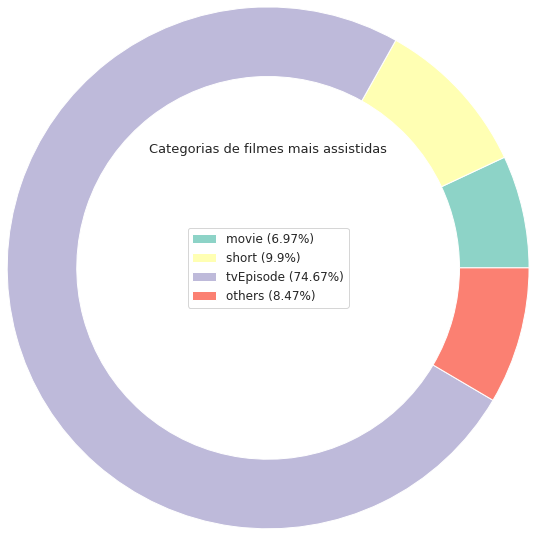

In [9]:
label = [str(categorias_mais_assistidas['type'][i]) + ' ' + '(' + str(round(categorias_mais_assistidas['COUNT'][i], 2)) + '%)' for i in range(len(categorias_mais_assistidas['type']))]

cs = cm.Set3(np.arange(100))
plt.title('Categorias de filmes mais assistidas', fontdict = {'fontsize':13, 'fontweight':13})
plt.pie(categorias_mais_assistidas['COUNT'], radius = 3, wedgeprops={'width':0.8}, colors = cs)
plt.legend(labels = label, loc = 'center', prop = {'size':12})

# Qual o Número de Títulos Por Gênero?

In [10]:
%%time
dados = pd.read_sql_query('SELECT genres, COUNT(*) AS COUNT FROM titles WHERE type = "movie" GROUP BY genres', conn)
dados

CPU times: user 940 ms, sys: 168 ms, total: 1.11 s
Wall time: 1.11 s


,genres,COUNT
0,Action,13738
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1449,"Thriller,Western",43
1450,War,1282
1451,"War,Western",13
1452,Western,5103


In [11]:
dados['genres'] = dados['genres'].str.lower().values
dados = dados['genres'].dropna()

In [12]:
padrao = '[\w-]+\\b'
vector = CountVectorizer(token_pattern = padrao, analyzer = 'word' ).fit(dados)
bag = vector.transform(dados)
generos_unicos = vector.get_feature_names()

In [13]:
generos = pd.DataFrame(bag.todense(), columns = generos_unicos, index = dados.index)
generos = generos.drop(columns = 'n', axis = 0)
resultado = pd.Series(100*generos.sum().sort_values(ascending = False)/generos.shape[0])

In [14]:
resultado = pd.Series(100*generos.sum().sort_values(ascending = False)/generos.shape[0])

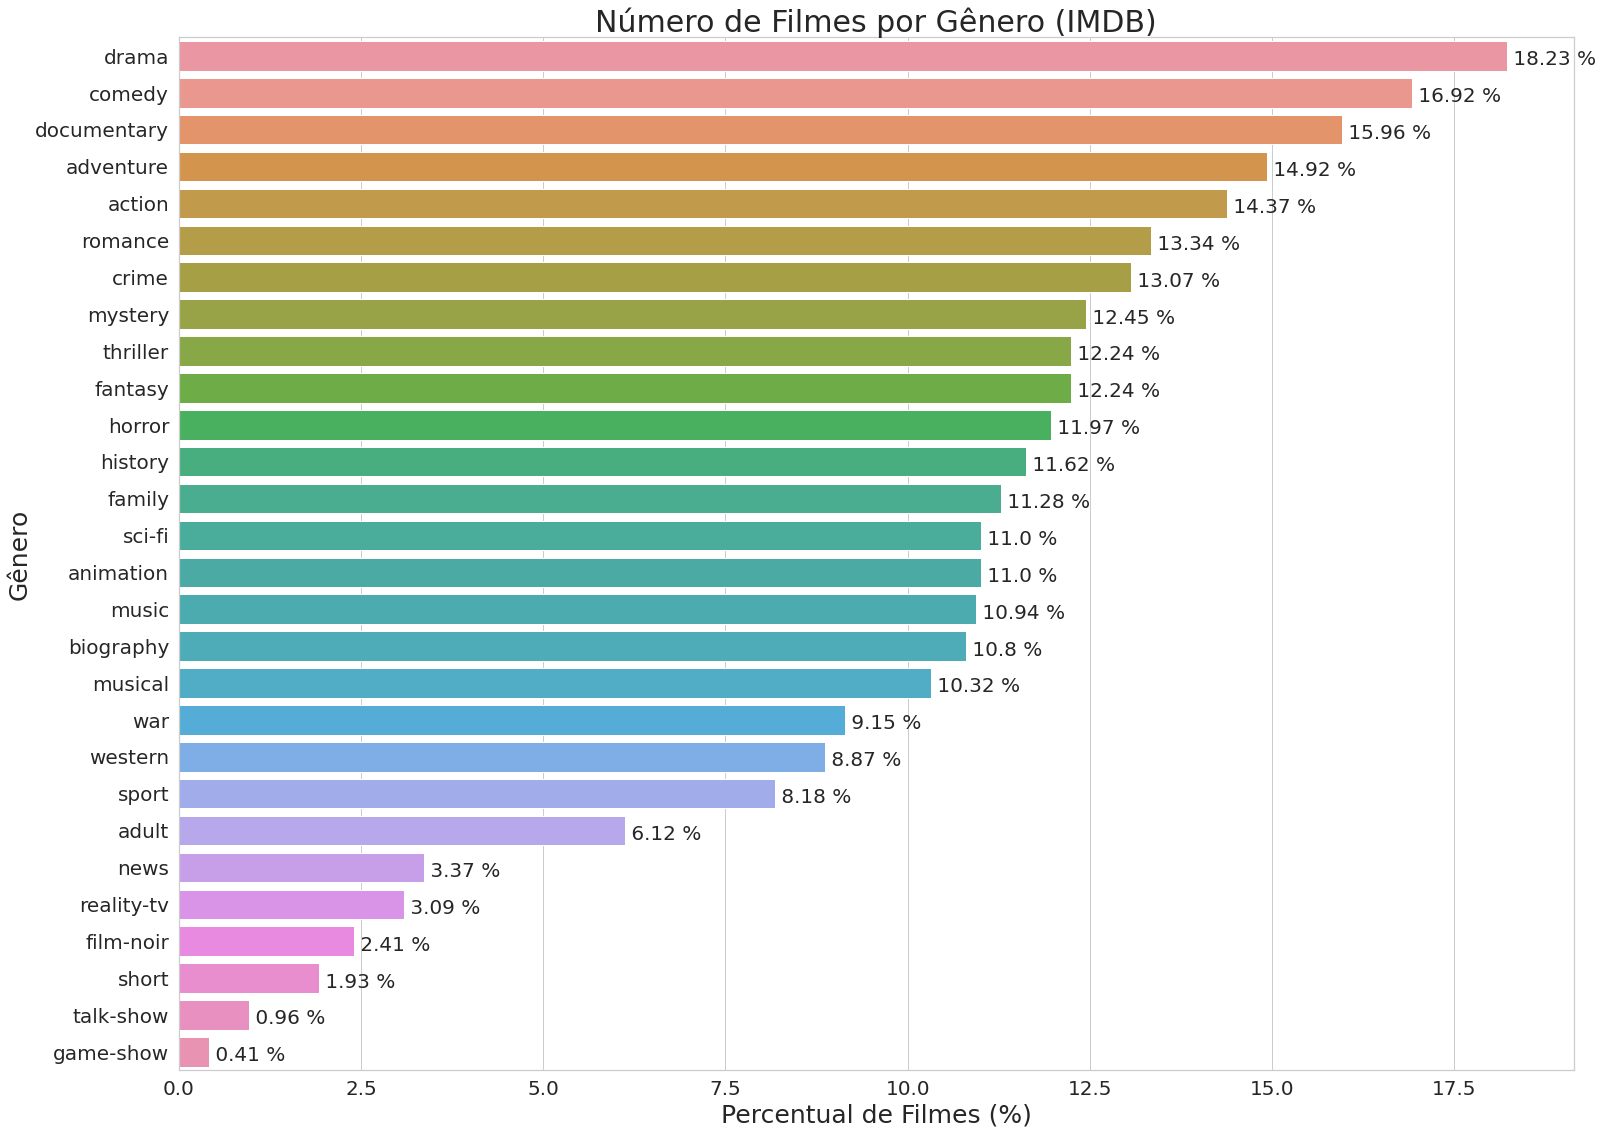

In [15]:
plt.figure(figsize = (25,19))
plt.title('Número de Filmes por Gênero (IMDB)', fontdict = {'fontsize':30, 'fontweight':30})
sns.barplot(x = resultado.values, y = resultado.index)
plt.ylabel('Gênero', fontsize = 25)
plt.xlabel('Percentual de Filmes (%)', fontsize = 25)
plt.tick_params(axis = 'both', labelsize = 20)

for i in range(len(resultado.index)):
    plt.text(resultado.values[i], i + 0.25, (' ' + str(round(resultado.values[i],2))) + ' %', fontsize = 20)

# Qual a mediana de avaliação dos Filmes por gênero?

In [16]:
%%time
avaliacoes = pd.read_sql_query('SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE type = "movie"', conn)
avaliacoes

CPU times: user 1.72 s, sys: 316 ms, total: 2.04 s
Wall time: 2.05 s


,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
273444,3.5,"Action,Adventure,Thriller"
273445,5.8,Thriller
273446,6.4,"Drama,History"
273447,3.8,"Adventure,History,War"


In [17]:
def generos_unicos(df):
    df['genres'] = df['genres'].str.lower().values
    df = df['genres'].dropna()
    padrao = '[\w-]+\\b'
    vector = CountVectorizer(token_pattern = padrao, analyzer = 'word' ).fit(dados)
    bag = vector.transform(dados)
    generos_unicos = vector.get_feature_names()
    generos_unicos = [i for i in generos_unicos if len(i) > 1]
    return generos_unicos

In [18]:
generos = generos_unicos(avaliacoes)

In [19]:
%%time
genero_counts = []
genero_ratings = []

for genero in generos:
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id  WHERE genres LIKE' + "\'" + '%' + genero + '%' + "\' AND type = 'movie'"
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE' + "\'" + '%' + genero + '%' + "\' AND type = 'movie'"
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])

CPU times: user 32.7 s, sys: 12.3 s, total: 45 s
Wall time: 45.1 s


In [20]:
avaliacoes_genero = pd.DataFrame({'generos':generos,
                                  'COUNTS':genero_counts,
                                  'ratings':genero_ratings})
avaliacoes_genero = avaliacoes_genero.sort_values(by = 'ratings', ascending = False, ignore_index = True)
avaliacoes_genero.head()

,generos,COUNTS,ratings
0,documentary,40411,7.3
1,news,652,7.3
2,short,24,7.2
3,biography,8239,7.0
4,history,7516,6.9


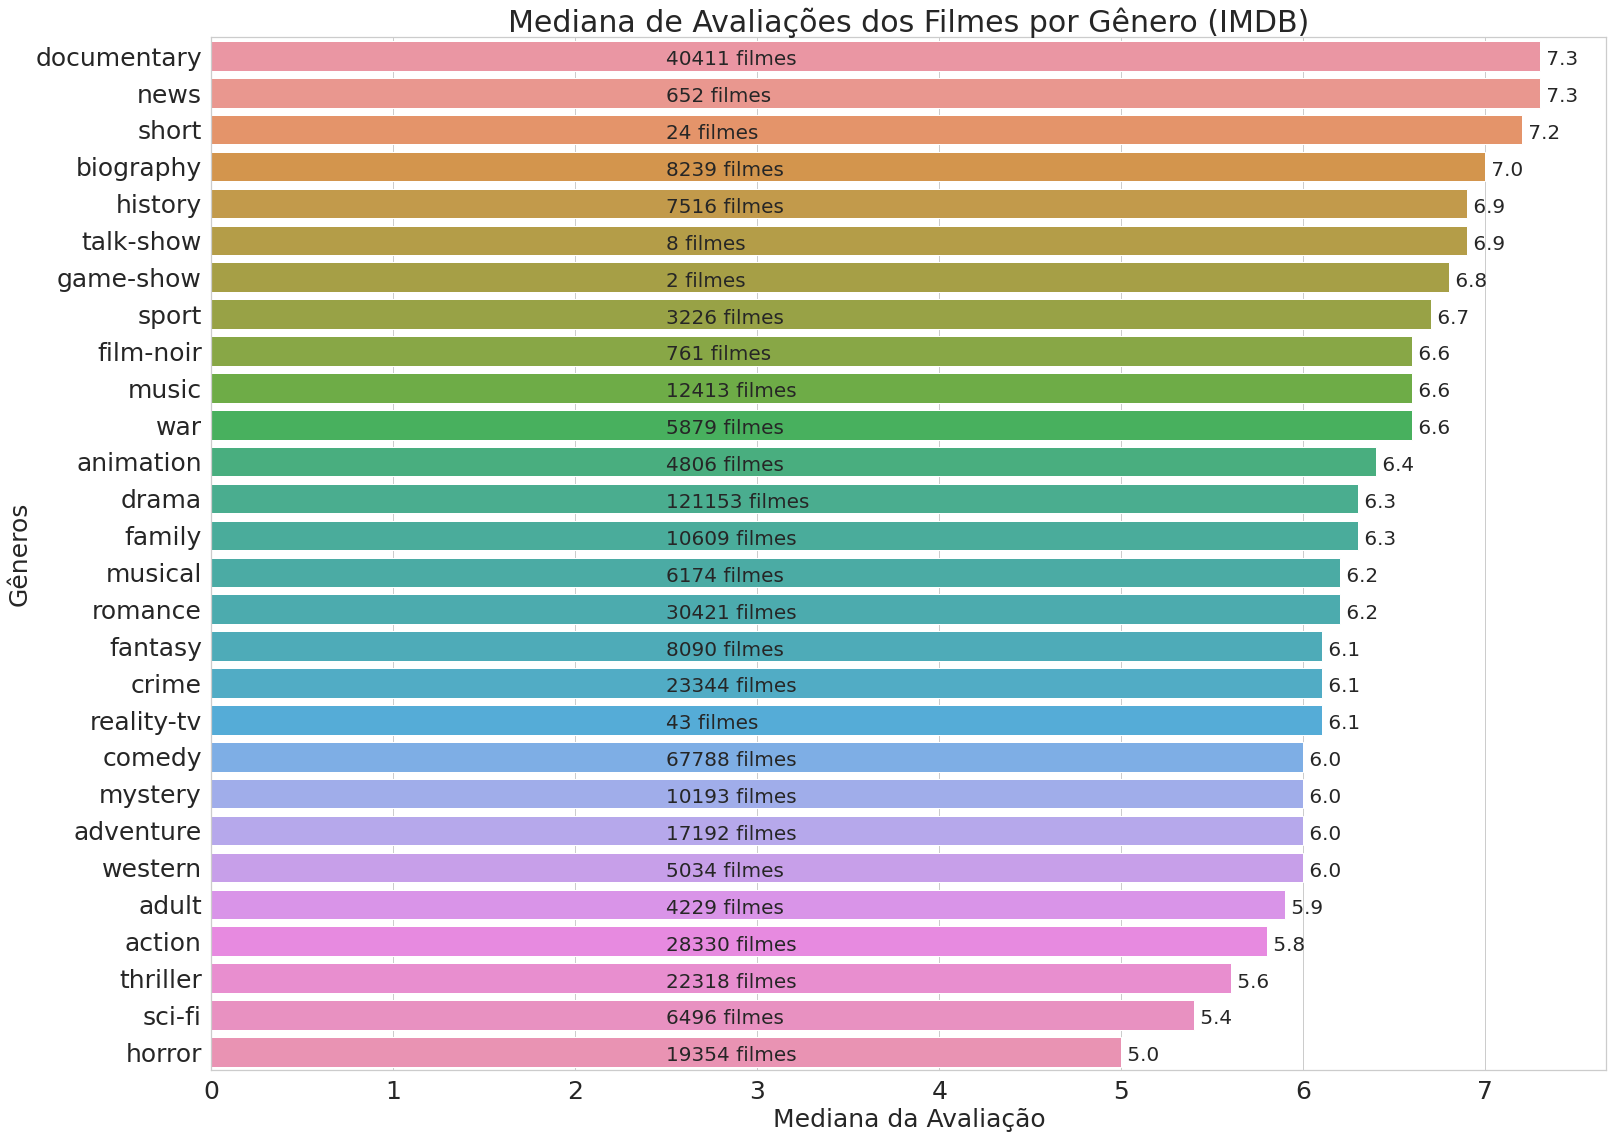

In [21]:
plt.figure(figsize = (25,19))
plt.title('Mediana de Avaliações dos Filmes por Gênero (IMDB)', fontdict = {'fontsize':30, 'fontweight':30})
sns.barplot(x = avaliacoes_genero.ratings, y = avaliacoes_genero.generos, orient = 'h')
plt.xlabel('Mediana da Avaliação', fontsize = 25)
plt.ylabel('Gêneros', fontsize = 25)
plt.tick_params(axis = 'both', labelsize = 25)


for i in range(len(avaliacoes_genero.index)):
    
    plt.text(2.5,
            i +  0.25,
            str(avaliacoes_genero.COUNTS[i]) + ' filmes', fontsize = 20)
    
    plt.text(avaliacoes_genero.ratings[i],
             i + 0.25,
             ' ' + str(round(avaliacoes_genero.ratings[i],2)), fontsize = 20)

# Qual a mediana de Avaliação dos Filmes em relação ao ano de estreia?

In [22]:
consulta = 'SELECT rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE type = "movie" ORDER BY premiered'
avaliacoes_ano = pd.read_sql_query(consulta, conn)
avaliacoes_ano = avaliacoes_ano.dropna()
avaliacoes_ano.premiered = avaliacoes_ano.premiered.astype('int64') 
avaliacoes_ano.head()

,rating,premiered
28,6.2,1896
29,4.5,1897
30,3.9,1899
31,3.7,1899
32,6.0,1900


In [23]:
avaliacoes_ano = avaliacoes_ano.groupby('premiered').median().reset_index()
avaliacoes_ano.head()

,premiered,rating
0,1896,6.20
1,1897,4.50
2,1899,3.80
3,1900,5.85
4,1901,4.60


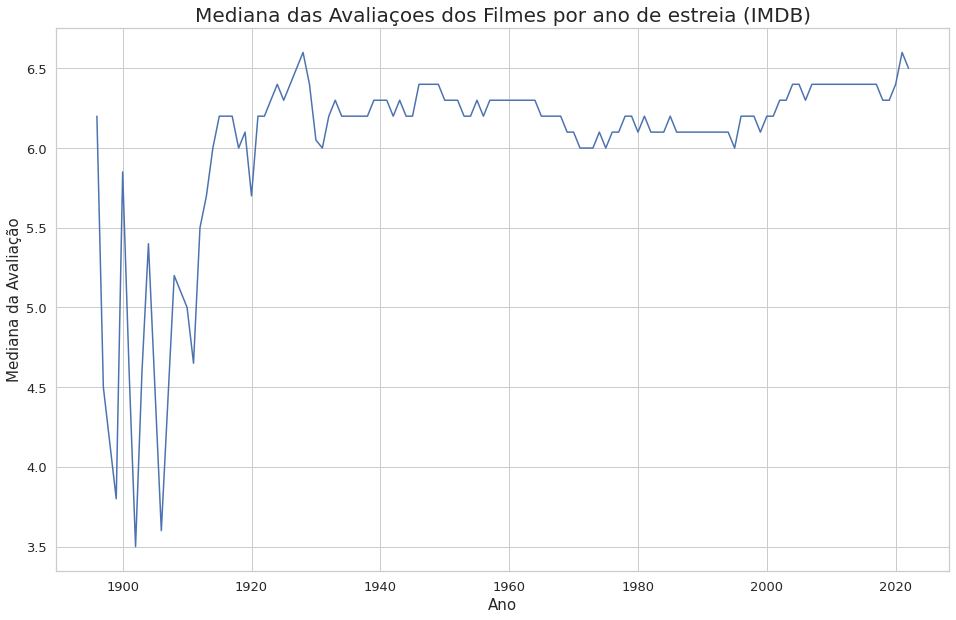

In [24]:
plt.figure(figsize = (16,10))
plt.plot(avaliacoes_ano.premiered, avaliacoes_ano.rating)
plt.title('Mediana das Avaliaçoes dos Filmes por ano de estreia (IMDB)', fontdict = {'fontsize':20, 'fontweight':20})
plt.xlabel('Ano', fontsize = 15)
plt.ylabel('Mediana da Avaliação', fontsize = 15)
plt.tick_params(axis = 'both', labelsize = 13)

plt.show()

# Qual o Número de Filmes avaliados por gênero em relação ao ano de estreia?

In [25]:
%%time
consulta = 'SELECT genres FROM titles'
resultado = pd.read_sql_query(consulta, conn)
resultado.head()

CPU times: user 8.46 s, sys: 1.06 s, total: 9.52 s
Wall time: 10.2 s


,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"


In [26]:
generos = generos_unicos(resultado)
print(generos)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']


In [27]:
%%time 
genero_count = []

for genero in generos:
    consulta = 'SELECT COUNT(*) AS COUNT FROM titles WHERE genres LIKE' + "\'" + '%' + genero + '%' + "\'"
    result =  pd.read_sql_query(consulta, conn)
    genero_count.append(result.values[0][0])

CPU times: user 46 s, sys: 8.46 s, total: 54.5 s
Wall time: 54.5 s


In [28]:
df_generos = pd.DataFrame({'generos':generos,'count':genero_count}).sort_values('count', ascending = False)
top_generos = df_generos.head().generos.values
top_generos

array(['drama', 'comedy', 'talk-show', 'short', 'documentary'],
      dtype=object)

In [29]:
plt.legend?

CPU times: user 12.7 s, sys: 1.4 s, total: 14.1 s
Wall time: 14.1 s


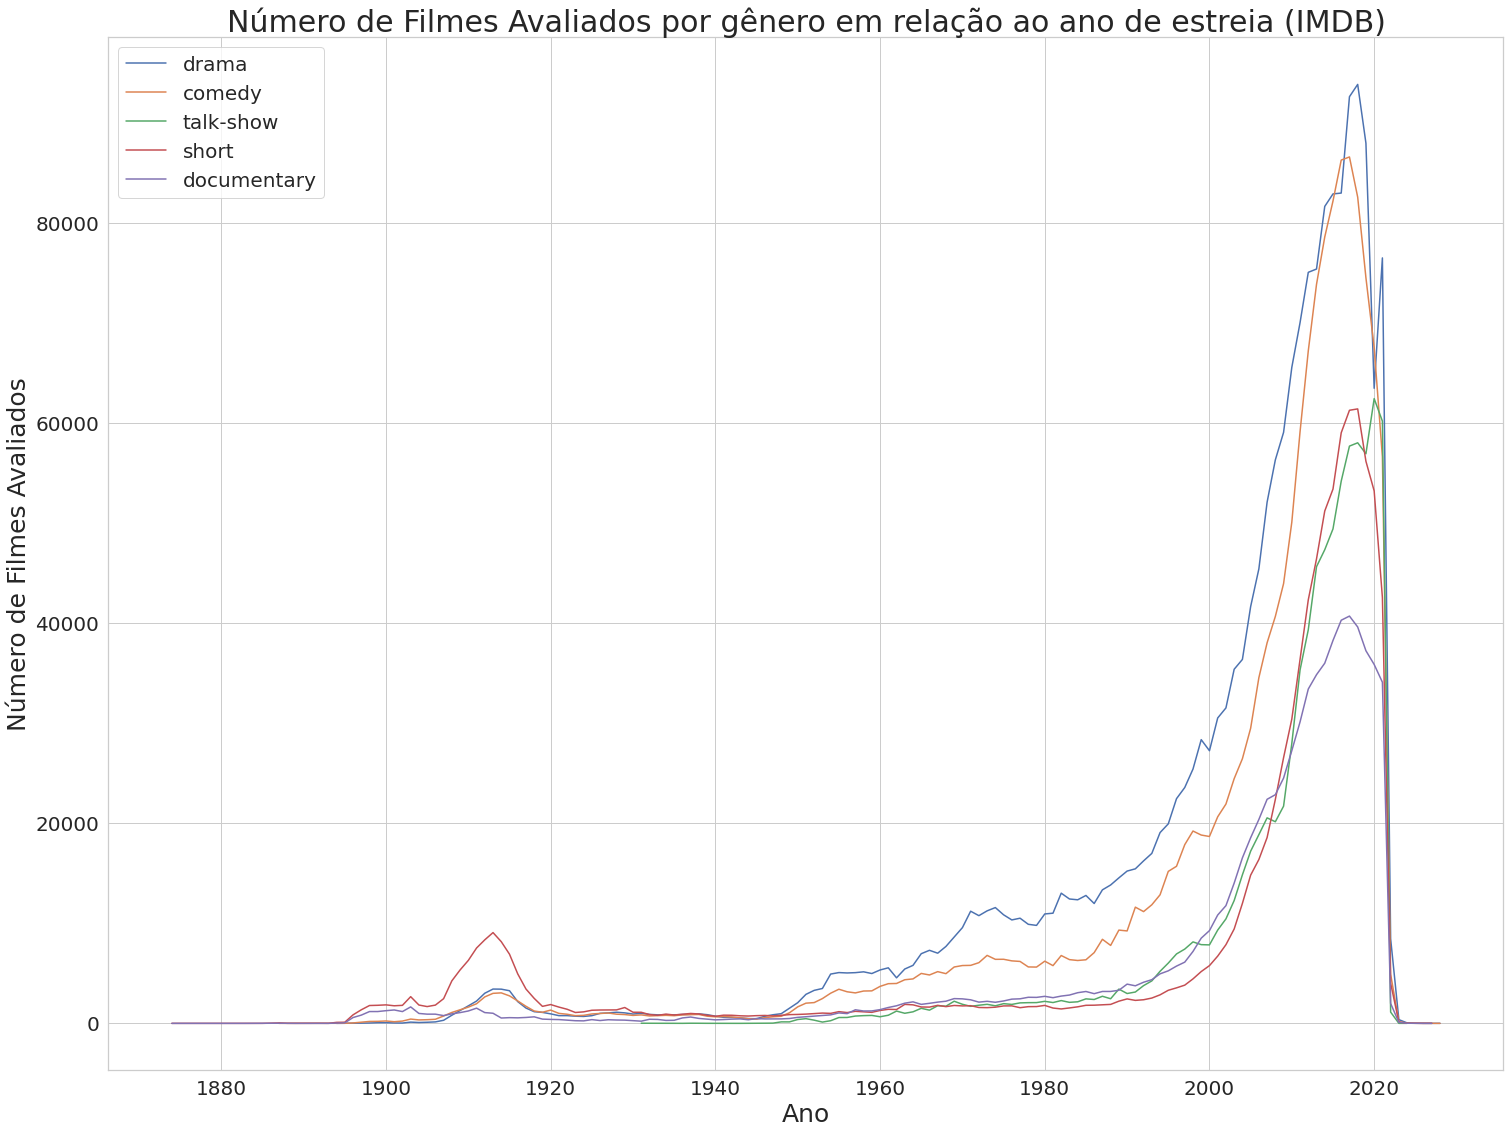

In [30]:
%%time

plt.figure(figsize = (25,19))
for genero in top_generos:
    consulta = 'SELECT COUNT(*) AS COUNT, premiered AS Year FROM titles WHERE genres LIKE' + "\'" + '%' + genero + '%' + "\' GROUP BY Year ORDER BY Year"
    resultado = pd.read_sql_query(consulta, conn).sort_values(by = 'Year', ascending = True)
    plt.plot(resultado['Year'], resultado['COUNT'])
    
plt.title('Número de Filmes Avaliados por gênero em relação ao ano de estreia (IMDB)', fontdict = {'fontsize':30, 'fontweight':30})
plt.xlabel('Ano', fontsize = 25)
plt.ylabel('Número de Filmes Avaliados', fontsize = 25)
plt.legend(labels = top_generos, fontsize = 20)
plt.tick_params(axis = 'both', labelsize = 20)

# Qual o filme com maior tempo de duração?

In [31]:
%%time

consulta = 'SELECT primary_title, runtime_minutes FROM titles WHERE type = "movie"'
resultado = pd.read_sql_query(consulta, conn)
resultado = resultado.sort_values('runtime_minutes', ascending = False)
resultado.head(1)

CPU times: user 1.28 s, sys: 228 ms, total: 1.51 s
Wall time: 1.51 s


,primary_title,runtime_minutes
567876,Logistics,51420.0


# Qual a Relação Entre Duração e Gênero? 

In [32]:
%%time
consulta = '''SELECT AVG(runtime_minutes), genres
              FROM titles 
              WHERE type = "movie" AND runtime_minutes != "NaN"
              GROUP BY genres'''

resultado = pd.read_sql_query(consulta, conn)
resultado = resultado.dropna()
resultado

CPU times: user 746 ms, sys: 192 ms, total: 938 ms
Wall time: 936 ms


,AVG(runtime_minutes),genres
0,99.287314,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1364,94.625000,"Thriller,Western"
1365,94.111296,War
1366,93.636364,"War,Western"
1367,70.643929,Western


In [33]:
generos = generos_unicos(resultado)
print(generos)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']


In [34]:
consulta = 'SELECT runtime_minutes FROM titles WHERE genres LIKE' + "\'" + '%' + generos[0] + '%' + "\' AND type = 'movie'" 
resultado = pd.read_sql_query(consulta, conn).dropna()
resultado

,runtime_minutes
0,70.0
2,50.0
3,220.0
4,1428.0
5,105.0
...,...
50131,66.0
50141,45.0
50142,105.0
50148,102.0


In [35]:
np.median(resultado['runtime_minutes'])

94.0

In [36]:
%%time
runtime_count_generos = []

for genero in generos:
    consulta = 'SELECT runtime_minutes FROM titles WHERE genres LIKE' + "\'" + '%' + genero + '%' + "\' AND type = 'movie'" 
    resultado = pd.read_sql_query(consulta, conn).dropna()
    runtime_count_generos.append(np.median(resultado))

CPU times: user 14.4 s, sys: 5.19 s, total: 19.6 s
Wall time: 19.6 s


In [37]:
runtime_count_generos

[94.0,
 77.0,
 90.0,
 81.0,
 87.0,
 91.0,
 92.0,
 74.0,
 93.0,
 89.0,
 90.0,
 83.0,
 57.5,
 90.0,
 88.0,
 90.0,
 93.0,
 91.0,
 75.0,
 90.0,
 95.0,
 90.0,
 19.0,
 90.0,
 74.5,
 92.0,
 93.0,
 72.0]

In [38]:
df_runtime_count_generos = pd.DataFrame({'generos':generos,'runtime_count':runtime_count_generos})
df_runtime_count_generos = df_runtime_count_generos.sort_values('runtime_count', ascending=False, ignore_index=True)

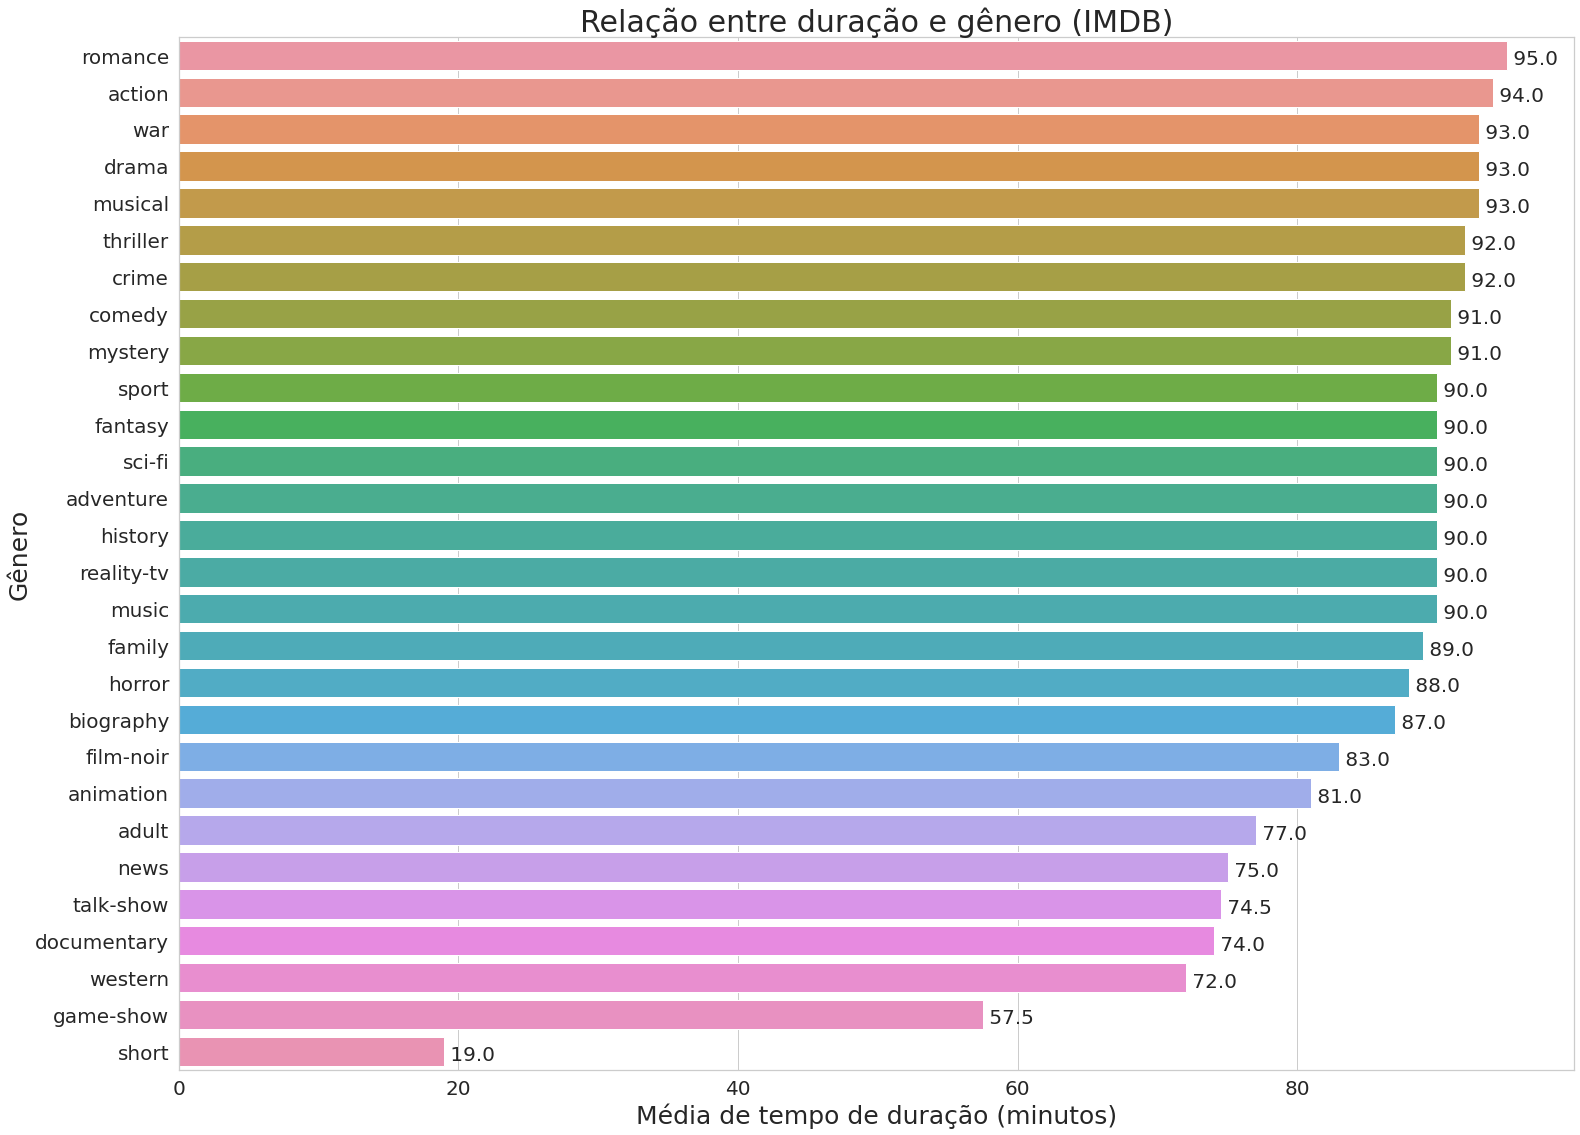

In [39]:
fig, ax = plt.subplots(figsize = (25,19))

plt.title('Relação entre duração e gênero (IMDB)', fontdict = {'fontsize':30,'fontweight':30})
sns.barplot(y = df_runtime_count_generos.generos, x = df_runtime_count_generos.runtime_count, orient = 'h', ax = ax)

plt.xlabel('Média de tempo de duração (minutos)', fontsize = 25)
plt.ylabel('Gênero', fontsize = 25)
plt.tick_params(axis = 'both', labelsize = 20)

for i in range(len(df_runtime_count_generos.runtime_count)):
    plt.text(x = df_runtime_count_generos.runtime_count[i], y = i + 0.25, 
            s = ' ' + (str(df_runtime_count_generos.runtime_count[i])), fontsize = 20)

# Qual o Número de Filmes Produzidos Por País? 

In [40]:
%%time 
consulta = 'SELECT region, COUNT(*) AS COUNT FROM akas JOIN titles ON akas.title_id = titles.title_id WHERE type = "movie" GROUP BY region ORDER BY COUNT DESC'
resultado = pd.read_sql_query(consulta, conn).dropna()
resultado

CPU times: user 4.13 s, sys: 669 ms, total: 4.8 s
Wall time: 4.8 s


,region,COUNT
1,US,304779
2,GB,156654
3,JP,89984
4,XWW,87822
5,FR,83328
...,...,...
230,NC,1
231,MS,1
232,MP,1
233,KN,1


In [41]:
resultado['region'].values[0]

'US'

In [42]:
paises_nome = []
contagem = []
for i in range(resultado.shape[0]):
    try:
        country = resultado['region'].values[i]
        paises_nome.append(pycountry.countries.get(alpha_2 = country).name)
        contagem.append(resultado['COUNT'].values[i])
    except:
        continue

In [43]:
len(paises_nome)

213

In [44]:
filmes_pais = pd.DataFrame({'Pais_nomes':paises_nome,'Filmes_Numero':contagem}).sort_values('Filmes_Numero', ascending=False)
filmes_pais = filmes_pais.dropna()
filmes_pais.head(10)

,Pais_nomes,Filmes_Numero
0,United States,304779
1,United Kingdom,156654
2,Japan,89984
3,France,83328
4,India,77932
5,Canada,74564
6,Germany,69019
7,Italy,64648
8,Spain,64250
9,Brazil,64151


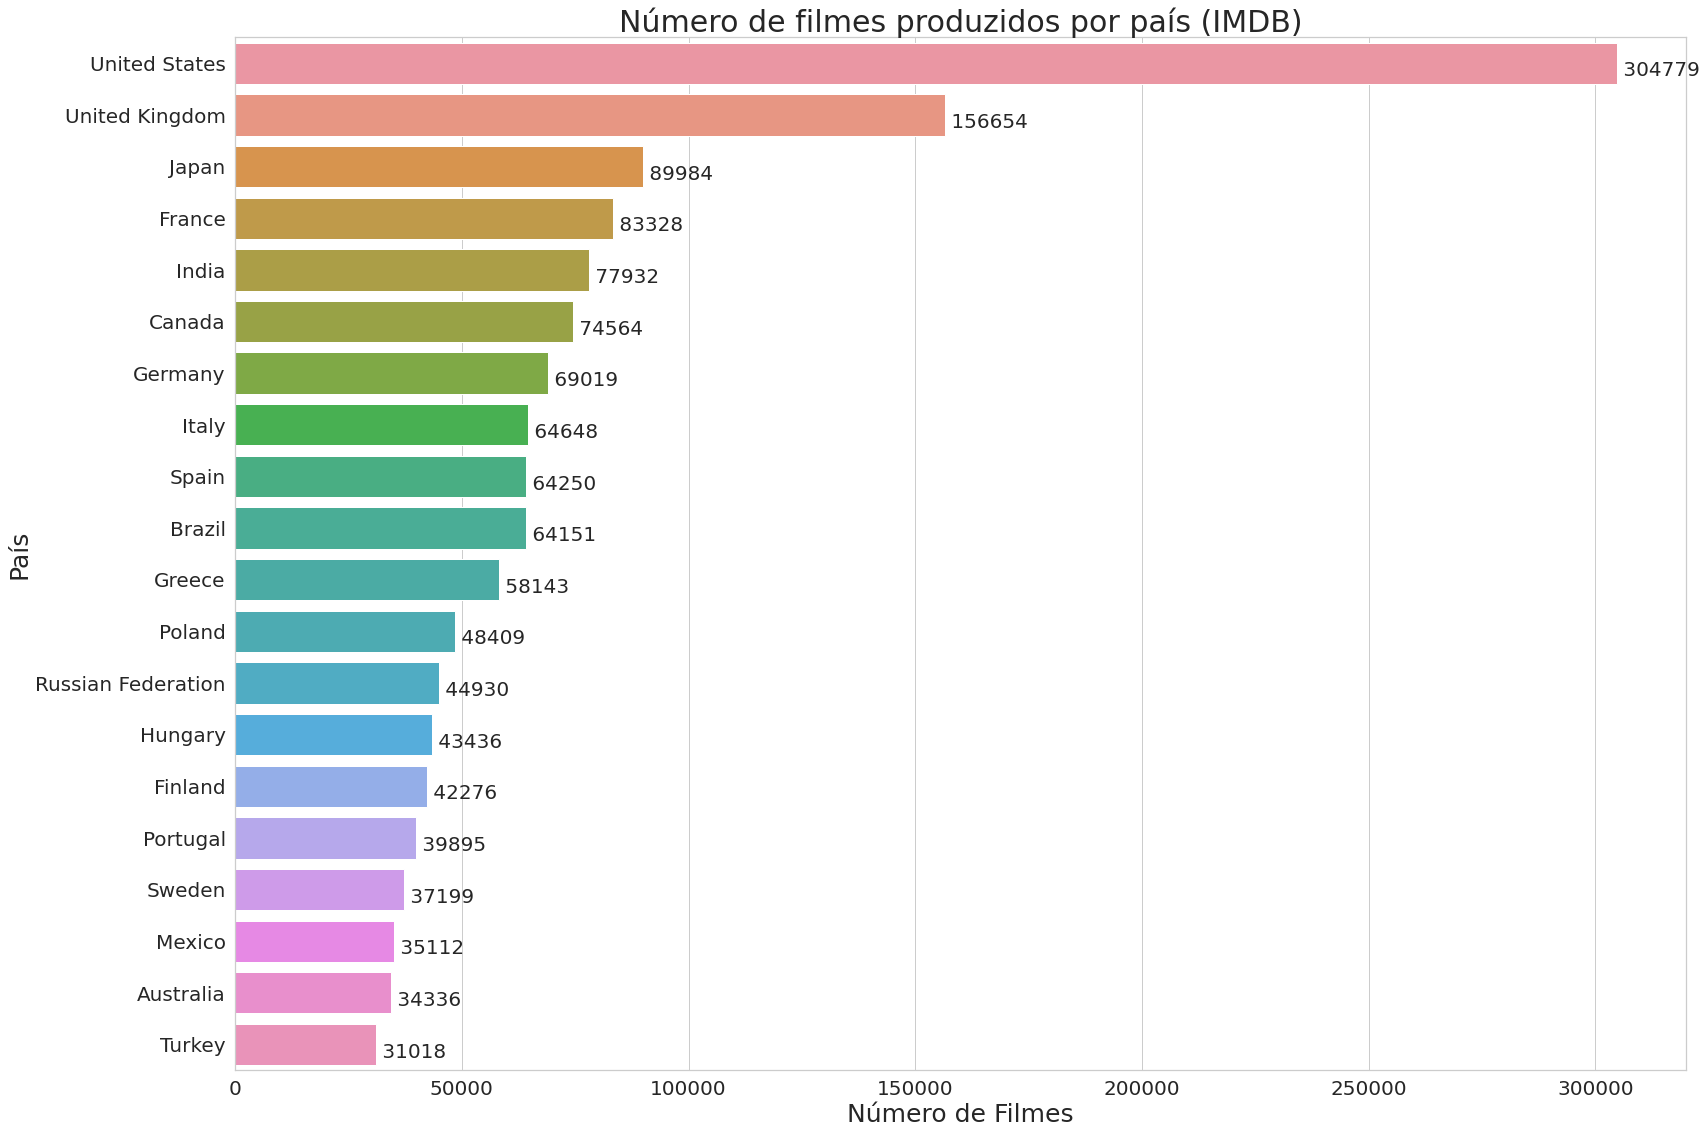

In [45]:
fig, ax = plt.subplots(figsize = (26,19))

plt.title('Número de filmes produzidos por país (IMDB)', fontdict = {'fontsize':30,'fontweight':30})
sns.barplot(x = filmes_pais.Filmes_Numero[:20] , y = filmes_pais.Pais_nomes[:20], ax = ax, orient = 'h')

plt.ylabel('País', fontsize = 25)
plt.xlabel('Número de Filmes', fontsize = 25)
plt.tick_params(axis = 'both', labelsize = 20)

for i in range(len(filmes_pais[:20])):
    plt.text(x = filmes_pais.Filmes_Numero[i], y = i + 0.25,
            s = ' ' + str(filmes_pais.Filmes_Numero[i]), size = 20)

# Quais São os Top 10 Melhores Filmes? 

In [46]:
consulta = '''
              SELECT primary_title, rating FROM titles 
              JOIN ratings ON titles.title_id = ratings.title_id 
              WHERE titles.type = "movie" AND ratings.votes >= 2500
              ORDER BY rating DESC
              LIMIT 10
            '''

resultado = pd.read_sql_query(consulta, conn)
resultado

,primary_title,rating
0,The Silence of Swastik,10.0
1,Oru Canadian Diary,9.8
2,Methagu,9.5
3,Jai Bhim,9.4
4,The Shawshank Redemption,9.3
5,The Chaos Class,9.3
6,The Godfather,9.2
7,Mayabazar,9.2
8,Ramayana: The Legend of Prince Rama,9.1
9,Aguner Poroshmoni,9.1


# Quais São os Top 10 Piores Filmes?

In [47]:
consulta = '''
              SELECT primary_title, rating FROM titles 
              JOIN ratings ON titles.title_id = ratings.title_id 
              WHERE titles.type = "movie" AND ratings.votes >= 2500
              ORDER BY rating ASC
              LIMIT 10
            '''

resultado = pd.read_sql_query(consulta, conn)
resultado

,primary_title,rating
0,321 Action,1.0
1,Cumali Ceber,1.0
2,Sadak 2,1.1
3,Desh Drohi,1.2
4,Smolensk,1.2
5,Hanum & Rangga,1.2
6,Potato Salad,1.3
7,Gully,1.3
8,The Butterfly Ball,1.4
9,Kirk Cameron's Saving Christmas,1.4
